# **Fazendo os imports das libs:**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import nltk
import string

nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /home/jv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Baixando os dataframes de treino e teste:**

In [30]:
dataframe_baixado = True
try:
    df_train = pd.read_csv('../kaggle_train.csv')
    df_test = pd.read_csv('../kaggle_test.csv')
except FileNotFoundError:
    print("Certifique-se de que os arquivos 'kaggle_train.csv' e 'kaggle_test.csv' estão na raiz do projeto.")
    dataframe_baixado = False

if (dataframe_baixado):
    print("Dataframes baixados com sucesso!")

Dataframes baixados com sucesso!


# **Visualizando os dataframes baixados:**

In [31]:
print ("Shape do dataframe de treino: ", df_train.shape)
df_train.head()

Shape do dataframe de treino:  (800, 3)


,ID,text,label
0,706,Quem vive chorando são as feministas. Graças a...,0
1,887,"doida, sem amigos, mono teta, professora, corn...",1
2,439,só tem bolsominion falando mal da T.T. espumem...,0
3,705,"A bebida é um novo passaporte para o estrupo, ...",0
4,497,Eu jamais perdoaria. Eu seguiria a minha vida.,0


In [32]:
print ("Shape do dataframe de teste: ", df_test.shape)
df_test.head()

Shape do dataframe de teste:  (200, 2)


,ID,text
0,893,"às vezes eu penso ""putz, como eu queria uma na..."
1,555,Ja tem o video completo da audiencia no canal ...
2,858,@NOME pq vc eh antifeminista??
3,582,Não fluiu pq o Paulo mandou os mgtow pra cuca ...
4,561,Ou seja. Se for beber não transem. Ou toma um ...


# **Realizando pré-processamento do texto:**

In [33]:
# Definindo stopwords com a lib NLTK configurada para PT-BR
stop_words = list(nltk.corpus.stopwords.words('portuguese'))
                  
def pre_process_text(text: str) -> str:
    # Deixando o texto lowercase e removendo a pontuação
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    
    # Tokenização
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # Filtrando os tokens:
    # 1- não pode ser stopword
    # 2- ter mais de 3 caracteres (para evitar artigos, preposições e etc)
    # 3- O 1° caractere do token não pode ser número
    tokens = [word for word in tokens
              if word not in stop_words
              and len(word) > 1
              and not word[0].isdigit()]
    
    # Reconstruindo texto
    return ' '.join(tokens)

# Aplicando o pré-processamento do texto no dataframe
df_train['text_clean'] = df_train['text'].apply(pre_process_text)
df_test['text_clean'] = df_test['text'].apply(pre_process_text)

In [34]:
# Embaralhando o dataframe de treino
df_train = df_train.sample(frac=1, random_state=42)  

# Separando features e alvo
X = df_train['text']
y = df_train['label']

# Divisão simples treino/teste local 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenização
max_words = 10000  # tamanho do vocabulário
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding das sequências para um tamanho fixo
max_len = 100  # número máximo de tokens por sequência
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

print("Pré-processamento, split e tokenização concluídos!")
print("Número de palavras no vocabulário:", min(max_words, len(tokenizer.word_index)))
print("Tamanho das sequências:", X_train_pad.shape[1])

Pré-processamento, split e tokenização concluídos!
Número de palavras no vocabulário: 3312
Tamanho das sequências: 100


# **Treinamento da rede neural:**


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.utils import class_weight
import numpy as np

# Parâmetros
embedding_dim = 128   # dimensão dos vetores de embedding
max_len = X_train_pad.shape[1]
vocab_size = min(10000, len(tokenizer.word_index) + 1)

# Definindo a RNN
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(64, return_sequences=False))  
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilação
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Treinamento
history = model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8047 - loss: 0.5082 - val_accuracy: 0.8375 - val_loss: 0.4447
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8359 - loss: 0.4659 - val_accuracy: 0.8375 - val_loss: 0.4438
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8359 - loss: 0.4587 - val_accuracy: 0.8375 - val_loss: 0.4442
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8359 - loss: 0.4531 - val_accuracy: 0.8375 - val_loss: 0.4444
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8359 - loss: 0.4567 - val_accuracy: 0.8375 - val_loss: 0.4438
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8359 - loss: 0.4587 - val_accuracy: 0.8375 - val_loss: 0.4447
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8359 - loss: 0.4601 - val_accuracy: 0.8375 - val_loss: 0.4448
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8359 - loss: 0.4483 - val_accuracy: 0.8375 - v

# **Plotando a acurácia do modelo em gráfico:**

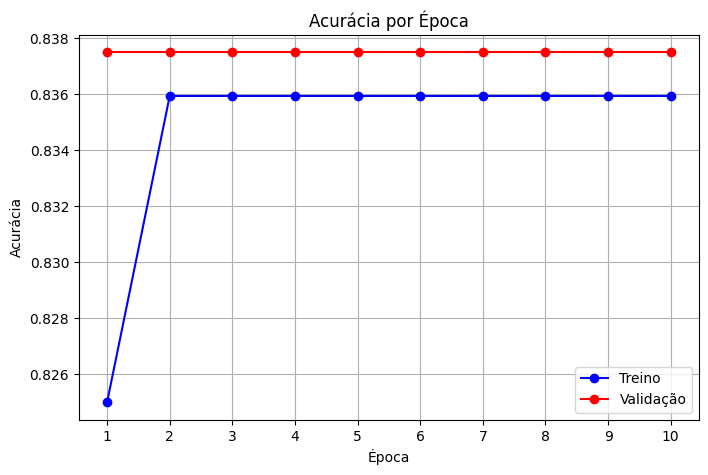

In [49]:
# Acurácia por época
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'ro-', label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()